In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the dataset
data = pd.read_csv('../data/energy.csv')
data.head()

,ON/OFF,PHASE,ACTIVE,REACTIVE,PHASE ANGLE,H1,H3,H5,H7,H9,...,H17,T1,T2,T3,T4,T5,T6,T7,T8,T9
0,1,0,54.6,-3.1,23.3,93.0,160.9,180.8,192.4,118.4,...,271.1,-100.0,-91.6,-79.3,-63.6,-45.1,-25.0,-4.2,16.3,36.1
1,1,1,30.0,51.5,25.3,81.1,18.7,234.1,310.0,36.4,...,238.7,-100.0,-91.4,-79.1,-63.5,-45.2,-25.3,-4.5,16.2,36.2
2,1,2,20.0,-44.6,20.5,38.7,3.8,41.8,38.5,1.9,...,20.1,-100.0,-91.2,-78.4,-62.4,-44.1,-24.6,-4.2,16.8,36.8
3,2,0,47.7,-3.1,20.3,90.5,158.6,177.1,198.9,117.7,...,298.2,100.0,92.4,80.1,63.9,44.8,24.2,3.1,-17.6,-37.5
4,2,1,28.5,47.7,23.5,78.4,13.9,228.1,312.6,33.9,...,257.8,100.0,93.6,82.3,66.8,48.3,27.8,6.5,-14.7,-35.3


In [3]:
def preprocess_phase_data(data, phase_value):
    # Filter for the specific phase
    phase_data = data[data['PHASE'] == phase_value].drop(columns=['PHASE', 'ON/OFF'])
    
    # Normalize data using MinMaxScaler
    scaler = MinMaxScaler()
    phase_data_normalized = scaler.fit_transform(phase_data)
    
    return phase_data_normalized, scaler, data[data['PHASE'] == phase_value].index

In [4]:
# Function to build and train an autoencoder model
def train_autoencoder(phase_data, phase_number):
    input_dim = phase_data.shape[1]
    encoding_dim = int(input_dim / 2)
    
    # Define the autoencoder model
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation="relu")(input_layer)
    decoder = Dense(input_dim, activation="sigmoid")(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    # Compile and train the model
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    history = autoencoder.fit(
        phase_data, phase_data,
        epochs=50,
        batch_size=32,
        shuffle=True,
        validation_split=0.2
    )
    
    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Phase {phase_number} Training')
    plt.legend()
    plt.show()
    
    return autoencoder

In [5]:
# Function to calculate reconstruction error and identify anomalies
def detect_anomalies(autoencoder, data, original_data, scaler):
    reconstructions = autoencoder.predict(data)
    reconstruction_errors = np.mean(np.square(data - reconstructions), axis=1)

    # Set the threshold for anomalies (mean + 3 * std as an example)
    threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
    
    # Identify indices of anomalies
    anomalous_indices = np.where(reconstruction_errors > threshold)[0]
    
    # Map these indices back to the original dataset
    original_indices = original_data.iloc[anomalous_indices].index
    
    # Inverse transform the normalized anomalies back to original scale
    anomalies_normalized = data[anomalous_indices]
    anomalies_original_scale = scaler.inverse_transform(anomalies_normalized)
    
    # Convert to DataFrame for saving
    anomalous_data = pd.DataFrame(anomalies_original_scale, columns=original_data.columns.drop(['PHASE', 'ON/OFF']))
    anomalous_data['Original_Index'] = original_indices
    
    return anomalous_data, reconstruction_errors

In [7]:
# Full pipeline to process each phase, train model, and save anomalies
def anomaly_detection_pipeline(data, phase_value):
    print(f"\nProcessing Phase {phase_value + 1}")
    
    # Preprocess phase data
    phase_data_normalized, scaler, original_indices = preprocess_phase_data(data, phase_value)
    original_phase_data = data.loc[original_indices].reset_index(drop=True)
    
    # Train autoencoder
    autoencoder = train_autoencoder(phase_data_normalized, phase_value + 1)
    
    # Detect anomalies
    anomalies, reconstruction_errors = detect_anomalies(autoencoder, phase_data_normalized, original_phase_data, scaler)
    
    # Save anomalies to CSV
    anomalies.to_csv(f'anomalies_phase_{phase_value + 1}.csv', index=False)
    print(f"Anomalies for Phase {phase_value + 1} saved to anomalies_phase_{phase_value + 1}.csv")
    
    return anomalies


Processing Phase 1
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0879 - val_loss: 0.0990
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0667 - val_loss: 0.0678
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0433 - val_loss: 0.0488
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286 - val_loss: 0.0368
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - val_loss: 0.0292
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - val_loss: 0.0244
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104 - val_loss: 0.0211
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - val_loss: 0.0190
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 - val_loss: 0.0176
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 0.0166
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043 - val_loss: 0.0162
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

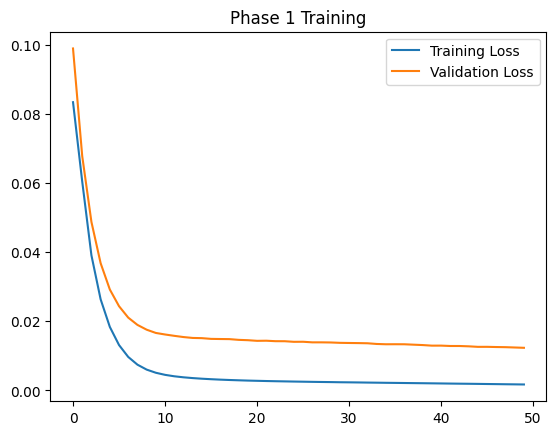

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Anomalies for Phase 1 saved to anomalies_phase_1.csv

Processing Phase 2
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1044 - val_loss: 0.0906
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0778 - val_loss: 0.0733
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0606 - val_loss: 0.0596
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - val_loss: 0.0478
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0337 - val_loss: 0.0380
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.0309
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - val_loss: 0.0265
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102 - val_loss: 0.0239
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0222
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0213
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

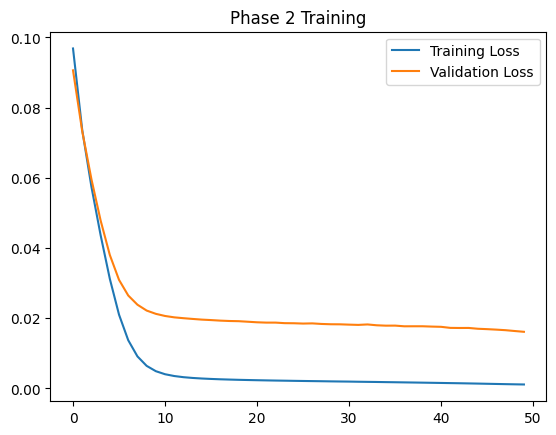

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
Anomalies for Phase 2 saved to anomalies_phase_2.csv

Processing Phase 3
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1302 - val_loss: 0.0901
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0850 - val_loss: 0.0706
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0490 - val_loss: 0.0660
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0330 - val_loss: 0.0609
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - val_loss: 0.0560
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - val_loss: 0.0523
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134 - val_loss: 0.0503
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.0488
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0477
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0468
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

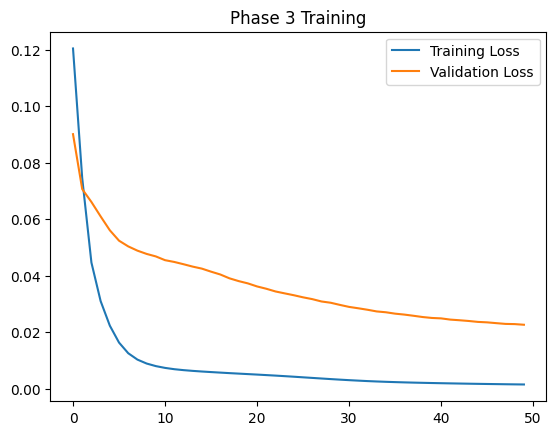

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
Anomalies for Phase 3 saved to anomalies_phase_3.csv


In [8]:
# Run the pipeline for each phase
anomalies_phase_1 = anomaly_detection_pipeline(data, 0)
anomalies_phase_2 = anomaly_detection_pipeline(data, 1)
anomalies_phase_3 = anomaly_detection_pipeline(data, 2)